# Предсказание невыплаты кредита

### Подключение библиотек и скриптов 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score as f1
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train F1:\t" + str(round(f1(train_true_values, train_pred_values), 10)))
    print("Test F1:\t" + str(round(f1(test_true_values, test_pred_values), 10)))

### Загрузка данных

In [5]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
train_df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [7]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [8]:
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [11]:
train_df['Home Ownership'] = train_df['Home Ownership'].astype(str)
train_df['Years in current job'] = train_df['Years in current job'].astype(str)
train_df['Purpose'] = train_df['Purpose'].astype(str)
train_df['Term'] = train_df['Term'].astype(str)

## 1. EDA

In [12]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [13]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [14]:
feature_names = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
        'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
        'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

target_name = 'Credit Default'

### Целевая переменная

In [15]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Количественные переменные

In [16]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Номинативные переменные

In [17]:
train_df.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [18]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [19]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [20]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [21]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

## 2. Обработка выбросов

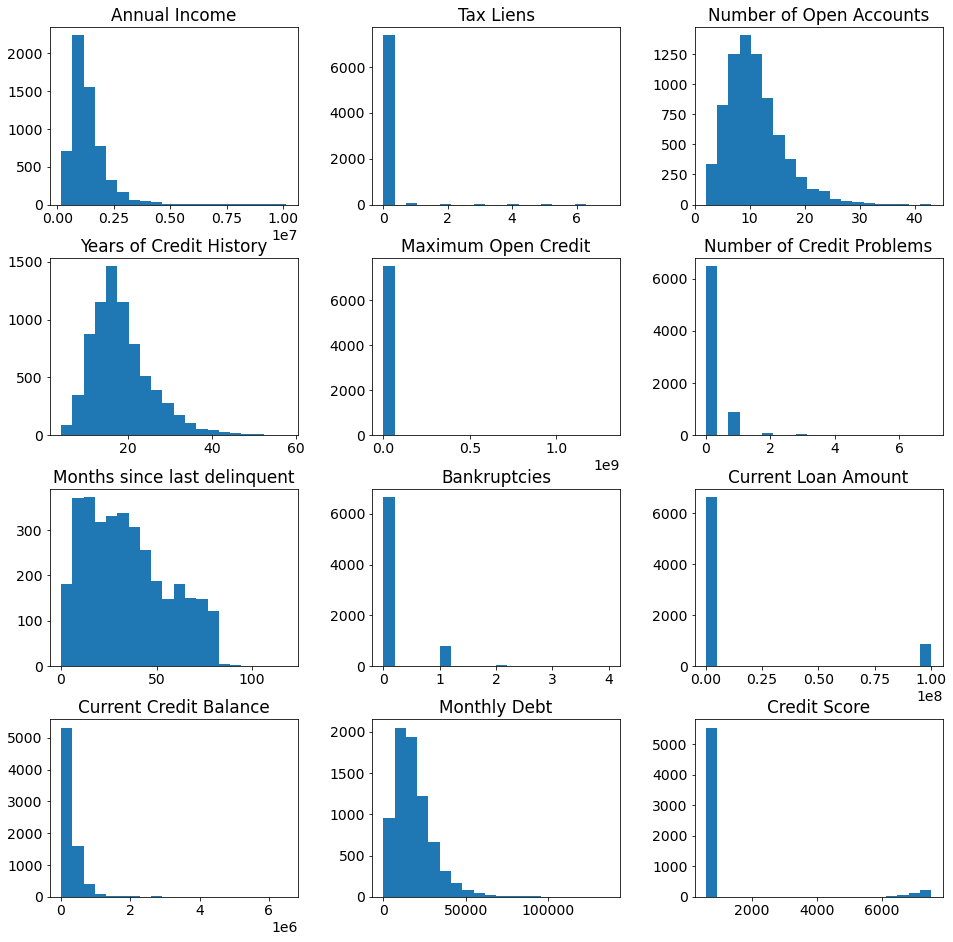

In [22]:
train_df[feature_names].hist(figsize=(16, 16), bins=20, grid=False);

### Tax Liens

In [23]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [24]:
train_df.loc[(train_df['Tax Liens'] != 0) & train_df['Tax Liens'].notna(), 'Tax Liens'] = 1

### Maximum Open Credit

In [25]:
train_df['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [26]:
train_df.loc[train_df['Maximum Open Credit'] > 10000000, 'Maximum Open Credit'] = train_df['Maximum Open Credit'].median()

### Number of Credit Problems

In [27]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [28]:
train_df.loc[(train_df['Number of Credit Problems'] != 0) 
             & train_df['Number of Credit Problems'].notna(), 'Number of Credit Problems'] = 1

### Bankruptcies

In [29]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [30]:
train_df.loc[(train_df['Bankruptcies'] != 0) & train_df['Bankruptcies'].notna(), 'Bankruptcies'] = 1

### Current Loan Amount

In [31]:
train_df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [32]:
train_df['Current Loan Amount outlier'] = 0
train_df.loc[(train_df['Current Loan Amount'] > 1000000) 
             & train_df['Current Loan Amount'].notna(), 'Current Loan Amount outlier'] = 1

train_df.loc[(train_df['Current Loan Amount'] > 1000000) 
             & train_df['Current Loan Amount'].notna(), 'Current Loan Amount'] = train_df['Current Loan Amount'].median()

### Credit Score

In [33]:
train_df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [34]:
train_df.loc[(train_df['Credit Score'] > 1000) 
             & train_df['Credit Score'].notna(), 'Credit Score'].value_counts()

7400.0    15
7300.0    13
7330.0    13
7170.0    12
7370.0    12
          ..
6830.0     1
6910.0     1
6450.0     1
6610.0     1
6170.0     1
Name: Credit Score, Length: 110, dtype: int64

In [35]:
train_df.loc[(train_df['Credit Score'] > 1000) 
             & train_df['Credit Score'].notna(), 'Credit Score'] = train_df.loc[(train_df['Credit Score'] > 1000) 
             & train_df['Credit Score'].notna(), 'Credit Score'] / 10

### Home Ownership

In [36]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [37]:
train_df.loc[train_df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

### Purpose

In [38]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [39]:
train_df.loc[train_df['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'

## 3. Обработка пропусков

In [40]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Current Loan Amount outlier        0
dtype: int64

### Annual Income

In [41]:
train_df['Annual Income outlier'] = 0
train_df.loc[train_df['Annual Income'].isna(), 'Annual Income outlier'] = 1

train_df.loc[train_df['Annual Income'].isna(), 'Annual Income'] = train_df['Annual Income'].median()

### Months since last delinquent

In [42]:
train_df.loc[train_df['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1

### Bankruptcies

In [43]:
train_df.loc[train_df['Bankruptcies'].isna(), 'Bankruptcies'] = train_df['Bankruptcies'].median()

### Credit Score

In [44]:
train_df['Credit Score outlier'] = 0
train_df.loc[train_df['Credit Score'].isna(), 'Credit Score outlier'] = 1

train_df.loc[train_df['Credit Score'].isna(), 'Credit Score'] = train_df['Credit Score'].median()

In [45]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
    def transform(self, X):
        """Трансформация данных"""
        
        # Приведение типов
        X['Home Ownership'] = X['Home Ownership'].astype(str)
        X['Years in current job'] = X['Years in current job'].astype(str)
        X['Purpose'] = X['Purpose'].astype(str)
        X['Term'] = X['Term'].astype(str)

        # Tax Liens
        X.loc[(X['Tax Liens'] != 0) & X['Tax Liens'].notna(), 'Tax Liens'] = 1
        
        # Maximum Open Credit
        X.loc[train_df['Maximum Open Credit'] > 10000000, 'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Number of Credit Problems
        X.loc[(X['Number of Credit Problems'] != 0) & X['Number of Credit Problems'].notna(), 'Number of Credit Problems'] = 1
        
        # Bankruptcies
        X.loc[(X['Bankruptcies'] != 0) & X['Bankruptcies'].notna(), 'Bankruptcies'] = 1
        
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.medians['Bankruptcies']
        
        # Current Loan Amount
        X['Current Loan Amount outlier'] = 0
        X.loc[(X['Current Loan Amount'] > 1000000) & X['Current Loan Amount'].notna(), 'Current Loan Amount outlier'] = 1

        X.loc[(X['Current Loan Amount'] > 1000000) 
              & X['Current Loan Amount'].notna(), 'Current Loan Amount'] = self.medians['Current Loan Amount']
            
        # Credit Score
        X.loc[(X['Credit Score'] > 1000) 
             & X['Credit Score'].notna(), 'Credit Score'] = X.loc[(X['Credit Score'] > 1000) 
             & X['Credit Score'].notna(), 'Credit Score'] / 10
        
        X['Credit Score outlier'] = 0
        X.loc[X['Credit Score'].isna(), 'Credit Score outlier'] = 1

        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']
        
        # Home Ownership
        X.loc[X['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        # Purpose
        X.loc[X['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'
        
        # Annual Income
        X['Annual Income outlier'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income outlier'] = 1

        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        # Months since last delinquent
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = -1
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

## 4. Построение новых признаков

### Dummies

#### Home Ownership

In [46]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [47]:
categories_to_numbers_Home_Ownership = {'Home Mortgage': 0, 'Rent': 1, 'Own Home': 2}

train_df['Home Ownership'] = train_df['Home Ownership'].map(categories_to_numbers_Home_Ownership)

#### Years in current job

In [48]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [49]:
categories_to_numbers_Years_in_current_job = {'nan': -1, '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, 
                            '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}

train_df['Years in current job'] = train_df['Years in current job'].map(categories_to_numbers_Years_in_current_job)

#### Purpose

In [50]:
train_df['Purpose'].value_counts()

debt consolidation    5944
other                 1556
Name: Purpose, dtype: int64

In [51]:
categories_to_numbers_Purpose = {'debt consolidation': 0, 'other': 1}

train_df['Purpose'] = train_df['Purpose'].map(categories_to_numbers_Purpose)

#### Term

In [52]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [53]:
categories_to_numbers_Term = {'Short Term': 0, 'Long Term': 1}

train_df['Term'] = train_df['Term'].map(categories_to_numbers_Term)

### KMeans_Clusters

In [54]:
scaler = StandardScaler(with_mean = False)
kmeans = KMeans(n_clusters=2, max_iter=400, random_state=42)

In [55]:
train_df_scaler = scaler.fit_transform(train_df)
train_df['KMeans_Clusters'] = kmeans.fit_predict(train_df)

In [56]:
train_df['KMeans_Clusters'].head()

0    1
1    1
2    1
3    1
4    1
Name: KMeans_Clusters, dtype: int32

In [57]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.categories_to_numbers_Home_Ownership = None
        self.categories_to_numbers_Years_in_current_job = None
        self.categories_to_numbers_Purpose = None
        self.categories_to_numbers_Term = None
        self.scaler = None
        self.kmeans = None
        self.df_scaler = None
        
    def fit(self, X):
        
        df = X.copy()
        
        # Categories to numbers
        self.categories_to_numbers_Home_Ownership = {'Home Mortgage': 0, 'Rent': 1, 'Own Home': 2}
        
        self.categories_to_numbers_Years_in_current_job = {'nan': -1, '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, 
                            '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
        
        self.categories_to_numbers_Purpose = {'debt consolidation': 0, 'other': 1}
        
        self.categories_to_numbers_Term = {'Short Term': 0, 'Long Term': 1}
            
        # KMeans_Clusters
        df['Home Ownership'] = df['Home Ownership'].map(self.categories_to_numbers_Home_Ownership)
        df['Years in current job'] = df['Years in current job'].map(self.categories_to_numbers_Years_in_current_job)
        df['Purpose'] = df['Purpose'].map(self.categories_to_numbers_Purpose)
        df['Term'] = df['Term'].map(self.categories_to_numbers_Term)

        self.scaler = StandardScaler(with_mean = False)
        self.kmeans = KMeans(n_clusters=2, max_iter=100, random_state=42)
        
        self.df_scaler = self.scaler.fit_transform(df)
        self.kmeans.fit(self.df_scaler)

    def transform(self, X):
        
        # Categories to numbers
        X['Home Ownership'] = X['Home Ownership'].map(self.categories_to_numbers_Home_Ownership)
        X['Years in current job'] = X['Years in current job'].map(self.categories_to_numbers_Years_in_current_job)
        X['Purpose'] = X['Purpose'].map(self.categories_to_numbers_Purpose)
        X['Term'] = X['Term'].map(self.categories_to_numbers_Term)
        
        # KMeans_Clusters   
        X_scaler = self.scaler.transform(X)
        X['KMeans_Clusters'] = self.kmeans.predict(X_scaler)
            
        return X

## 5. Отбор признаков

In [58]:
train_df.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Current Loan Amount outlier',
 'Annual Income outlier',
 'Credit Score outlier',
 'KMeans_Clusters']

In [59]:
feature_names = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
        'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 
        'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

new_feature_names = ['KMeans_Clusters']

target_name = 'Credit Default'

In [60]:
train_df.isna().sum().sum()

0

## 6. Разбиение на train и test

In [61]:
train_df = pd.read_csv("train.csv")

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3333, shuffle=True, random_state=42)

In [63]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((5000, 19), (2500, 19))

In [64]:
features_gen = FeatureGenetator()
features_gen.fit(X_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)

X_train.shape, X_valid.shape

((5000, 20), (2500, 20))

In [65]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]

X_train.shape, X_valid.shape

((5000, 17), (2500, 17))

In [66]:
X_train.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,KMeans_Clusters
count,5000.000000,5.000000e+03,5000.000000,5000.00000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,0.598600,1.323343e+06,5.540800,0.01660,11.156000,18.305860,6.484716e+05,0.140200,15.012000,0.113400,0.207000,0.258800,309835.842800,2.913896e+05,18231.139600,722.167800,0.205200
std,0.642776,7.477915e+05,3.827122,0.12778,4.915414,6.969183,6.900917e+05,0.347229,22.863989,0.317113,0.405196,0.438019,171449.781643,3.255963e+05,11689.012577,25.678729,0.403888
min,0.000000,1.758450e+05,-1.000000,0.00000,2.000000,4.300000,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,586.000000,0.000000
25%,0.000000,9.320212e+05,2.000000,0.00000,8.000000,13.500000,2.843170e+05,0.000000,-1.000000,0.000000,0.000000,0.000000,181236.000000,1.157195e+05,10114.000000,715.000000,0.000000
50%,1.000000,1.168424e+06,6.000000,0.00000,10.000000,17.000000,4.772405e+05,0.000000,-1.000000,0.000000,0.000000,0.000000,309699.500000,2.110520e+05,16181.500000,731.000000,0.000000
75%,1.000000,1.499418e+06,10.000000,0.00000,14.000000,21.800000,7.905590e+05,0.000000,29.000000,0.000000,0.000000,1.000000,396473.000000,3.588958e+05,23631.000000,738.000000,0.000000
max,2.000000,1.014934e+07,10.000000,1.00000,43.000000,51.500000,9.541136e+06,1.000000,118.000000,1.000000,1.000000,1.000000,788788.000000,6.506797e+06,136679.000000,751.000000,1.000000


In [67]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

## 7. Построение модели

### Обучение

In [68]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.597122302158273

In [69]:
gb_model = XGBClassifier(max_delta_step=1000000,
             num_parallel_tree=10,
             colsample_bytree=0.3, 
             learning_rate=0.03,
             max_depth=3,
             n_estimators=300,
             reg_lambda=14,
             scale_pos_weight = disbalance,
             subsample=0.6, seed=42)

gb_model.fit(X_train, y_train)

[04:29:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=1000000, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=10, random_state=42,
              reg_alpha=0, reg_lambda=14, scale_pos_weight=2.597122302158273,
              seed=42, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Оценка модели

In [70]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train F1:	0.5684658336
Test F1:	0.5107498689


### Кросс-валидация

In [71]:
cv_score = cross_val_score(gb_model, pd.concat([X_train, X_valid]),  
                           pd.concat([y_train, y_valid]), scoring='f1', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

[04:29:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.50102459, 0.53018373, 0.50412371])

In [72]:
cv_score.mean()

0.5117773428460871

### Важность признаков

In [73]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

In [74]:
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
11,Term,0.234234
12,Current Loan Amount,0.153574
15,Credit Score,0.097516
1,Annual Income,0.071662
6,Maximum Open Credit,0.046975
2,Years in current job,0.043776
0,Home Ownership,0.042033
14,Monthly Debt,0.041686
16,KMeans_Clusters,0.036042
5,Years of Credit History,0.035952


### Bagging

In [75]:
gb = XGBClassifier(max_delta_step=1000000,
             num_parallel_tree=10,
             colsample_bytree=0.3, 
             learning_rate=0.03,
             max_depth=3,
             n_estimators=300,
             reg_lambda=14,
             scale_pos_weight = disbalance,
             subsample=0.6, seed=42)

bag = BaggingClassifier(base_estimator=gb, n_estimators=10, random_state=42)
bag.fit(X_train, y_train)

[04:30:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

BaggingClassifier(base_estimator=XGBClassifier(base_score=None, booster=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.3, gamma=None,
                                               gpu_id=None,
                                               importance_type='gain',
                                               interaction_constraints=None,
                                               learning_rate=0.03,
                                               max_delta_step=1000000,
                                               max_depth=3,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=300, n_jobs=None,
            

In [76]:
y_train_preds = bag.predict(X_train)
y_test_preds = bag.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train F1:	0.5653116531
Test F1:	0.5150537634


## 8. Прогнозирование на тестовом датасете

### Максимальное бучение на всех данных

In [77]:
test_df = pd.read_csv("test.csv")
test_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [78]:
preprocessor = DataPreprocessing()
preprocessor.fit(X)

X = preprocessor.transform(X)
test_df = preprocessor.transform(test_df)

X.shape, test_df.shape

((7500, 19), (2500, 19))

In [79]:
features_gen = FeatureGenetator()
features_gen.fit(X)

X = features_gen.transform(X)
test_df = features_gen.transform(test_df)

X.shape, test_df.shape

((7500, 20), (2500, 20))

In [80]:
X = X[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

X.shape, test_df.shape

((7500, 17), (2500, 17))

In [81]:
X.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

In [82]:
X.describe()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,KMeans_Clusters
count,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,0.599733,1.325286e+06,5.540000,0.017867,11.130933,18.317467,6.433482e+05,0.137467,15.271067,0.110133,0.207467,0.259200,309088.029067,2.898332e+05,18314.454133,722.352533,0.792400
std,0.642372,7.567551e+05,3.831826,0.132476,4.908924,7.041946,6.743494e+05,0.344362,23.031689,0.313077,0.405520,0.438225,171393.740131,3.178714e+05,11926.764673,25.276816,0.405616
min,0.000000,1.645970e+05,-1.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,0.000000,9.311330e+05,2.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,-1.000000,0.000000,0.000000,0.000000,180169.000000,1.142565e+05,10067.500000,715.000000,1.000000
50%,1.000000,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781535e+05,0.000000,-1.000000,0.000000,0.000000,0.000000,309567.500000,2.093230e+05,16076.500000,731.000000,1.000000
75%,1.000000,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.905590e+05,0.000000,29.000000,0.000000,0.000000,1.000000,396929.500000,3.604062e+05,23818.000000,738.000000,1.000000
max,2.000000,1.014934e+07,10.000000,1.000000,43.000000,57.700000,9.541136e+06,1.000000,118.000000,1.000000,1.000000,1.000000,789030.000000,6.506797e+06,136679.000000,751.000000,1.000000


In [83]:
disbalance = y.value_counts()[0] / y.value_counts()[1]
disbalance

2.549455750118315

In [84]:
gb = XGBClassifier(max_delta_step=1000000,
             num_parallel_tree=10,
             colsample_bytree=0.3, 
             learning_rate=0.03,
             max_depth=3,
             n_estimators=300,
             reg_lambda=14,
             scale_pos_weight = disbalance,
             subsample=0.6, seed=42)

bag = BaggingClassifier(base_estimator=gb, n_estimators=10, random_state=42) # n_estimators=100
bag.fit(X, y)

[04:30:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:31:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

BaggingClassifier(base_estimator=XGBClassifier(base_score=None, booster=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.3, gamma=None,
                                               gpu_id=None,
                                               importance_type='gain',
                                               interaction_constraints=None,
                                               learning_rate=0.03,
                                               max_delta_step=1000000,
                                               max_depth=3,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=300, n_jobs=None,
            

### Прогнозирование

In [85]:
submit = pd.read_csv('submit.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [86]:
predictions = bag.predict(test_df)
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [87]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0


In [88]:
submit.to_csv('bag_xgb_submit.csv', index=False)